<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/DL_Models/01_cnn_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 374 (delta 70), reused 9 (delta 9), pack-reused 268 (from 2)
Receiving objects: 100% (374/374), 26.75 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
# Import libraries
import pandas as pd   # data processing
import numpy as np    # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, joblib, json
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

In [4]:
# -----------------------
# Load your splits
# -----------------------
train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [5]:
!unzip -o dl_preprocessed.zip

Archive:  dl_preprocessed.zip
  inflating: dl_data_windows.npz     
  inflating: label_encoder.pkl       
  inflating: scaler.pkl              


In [6]:
# -----------------------
# Load preprocessed arrays
# -----------------------
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]

le = joblib.load("label_encoder.pkl")
classes = le.classes_

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


Epoch 1/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6657 - loss: 0.0341 - val_accuracy: 0.7513 - val_loss: 0.0250
Epoch 2/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8205 - loss: 0.0161 - val_accuracy: 0.7276 - val_loss: 0.0226
Epoch 3/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8412 - loss: 0.0131 - val_accuracy: 0.8477 - val_loss: 0.0135
Epoch 4/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8429 - loss: 0.0123 - val_accuracy: 0.8359 - val_loss: 0.0159
Epoch 5/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8532 - loss: 0.0114 - val_accuracy: 0.7428 - val_loss: 0.0174
Epoch 6/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8527 - loss: 0.0117 - val_accuracy: 0.8562 - val_loss: 0.0117
Epoch 7/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8303 - loss: 0.0109 - val_accuracy: 0.8579 - val_loss: 0.0108
Epoch 8/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8776 - loss: 0.0094 - val_accu

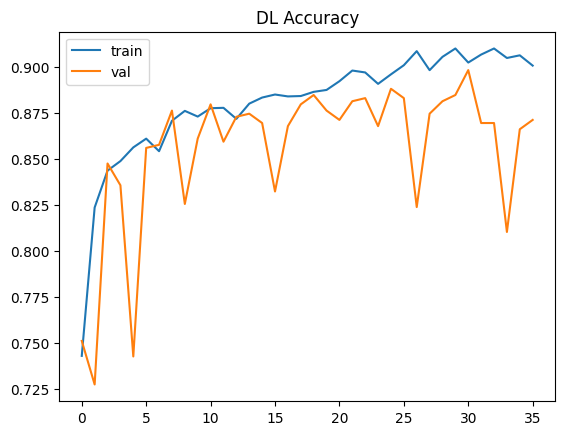

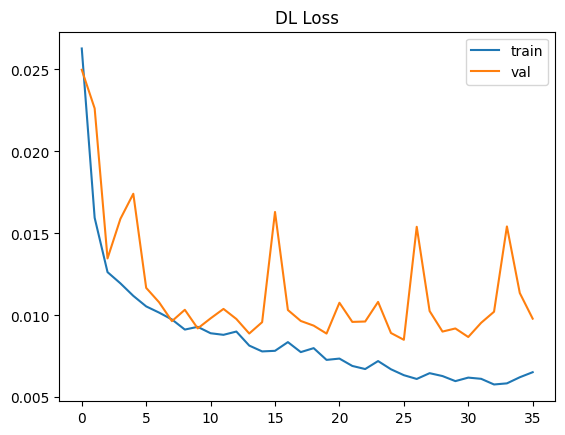

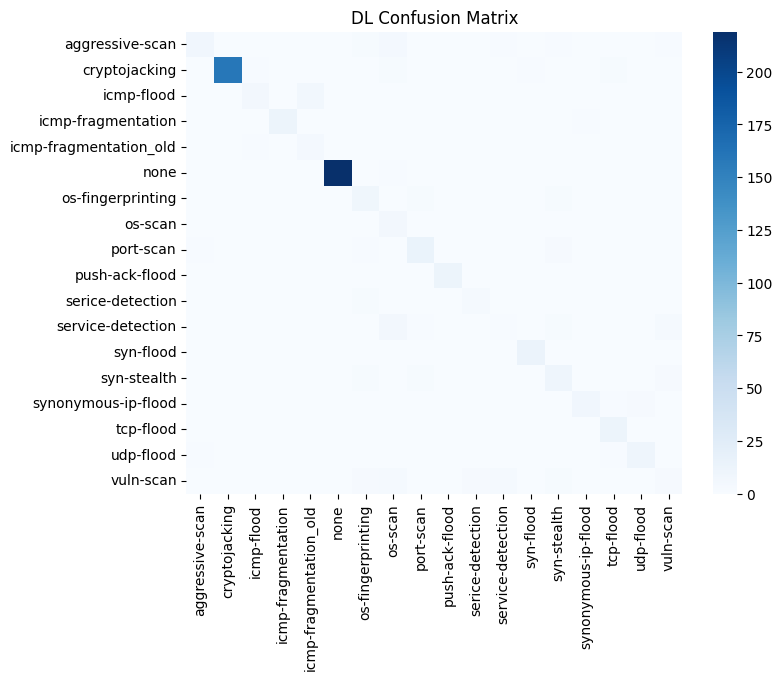

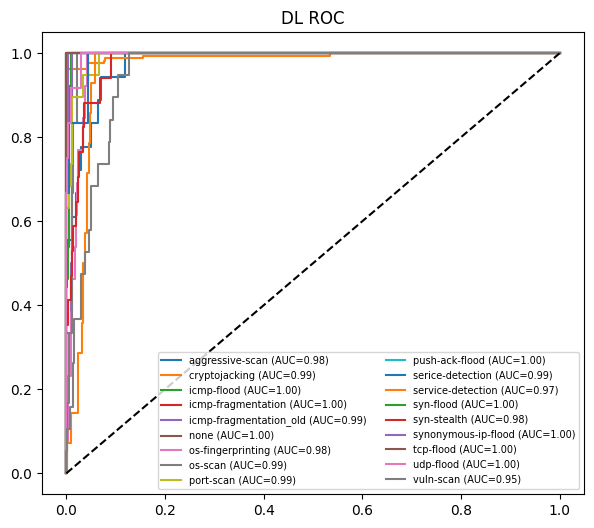

In [8]:
# --- Focal loss
def categorical_focal_loss(gamma=2.0, alpha=None):
    def loss(y_true, y_pred):
        y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0)
        ce = -tf.reduce_sum(y_true_oh * tf.math.log(y_pred), axis=-1)
        p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        modulating = tf.pow(1.0 - p_t, gamma)
        if alpha is not None:
            alpha_t = tf.reduce_sum(y_true_oh * tf.constant(alpha, dtype=tf.float32), axis=-1)
            fl = alpha_t * modulating * ce
        else:
            fl = modulating * ce
        return tf.reduce_mean(fl)
    return loss

cls_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
alpha = (cls_weights / np.sum(cls_weights)).astype(np.float32)

# --- Model
def build_cnn_tr(window, n_features, n_classes):
    inp = layers.Input(shape=(window, n_features))
    x = layers.Conv1D(96, 3, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dense(64)(x)
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn]); x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss=categorical_focal_loss(gamma=2, alpha=alpha), metrics=["accuracy"])
    return model

dl_model = build_cnn_tr(X_train.shape[1], X_train.shape[2], len(classes))

hist = dl_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=60, batch_size=32,
                    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                               callbacks.ModelCheckpoint("DL_final.keras", save_best_only=True)])

# --- Evaluate
y_proba_dl = dl_model.predict(X_test)
y_pred_dl  = y_proba_dl.argmax(axis=1)
acc_dl = accuracy_score(y_test, y_pred_dl)
f1_dl  = f1_score(y_test, y_pred_dl, average="macro")

print("\n📊 DL Classification Report:\n")
print(classification_report(y_test, y_pred_dl, target_names=classes, zero_division=0))
print(f"✅ Accuracy={acc_dl:.4f}, MacroF1={f1_dl:.4f}")

# --- Training curves
plt.figure(); plt.plot(hist.history["accuracy"], label="train"); plt.plot(hist.history["val_accuracy"], label="val")
plt.title("DL Accuracy"); plt.legend(); plt.savefig("dl_acc.png", dpi=200); plt.show()
plt.figure(); plt.plot(hist.history["loss"], label="train"); plt.plot(hist.history["val_loss"], label="val")
plt.title("DL Loss"); plt.legend(); plt.savefig("dl_loss.png", dpi=200); plt.show()

# --- Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dl)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("DL Confusion Matrix"); plt.savefig("cm_dl.png", dpi=200); plt.show()

# --- ROC
y_true_bin = label_binarize(y_test, classes=np.arange(len(classes)))
plt.figure(figsize=(7,6))
for i, name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba_dl[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_proba_dl[:, i])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'k--'); plt.legend(fontsize=7, ncol=2)
plt.title("DL ROC"); plt.savefig("roc_dl.png", dpi=200); plt.show()

# --- Save
np.save("proba_dl.npy", y_proba_dl)
with open("results_dl.json","w") as f:
    json.dump({"accuracy": float(acc_dl), "macro_f1": float(f1_dl),
               "report": classification_report(y_test, y_pred_dl, target_names=classes, zero_division=0),
               "confusion_matrix": cm.tolist()}, f, indent=2)